In [107]:
import osnap
import pickle
import pandas as pd
import numpy as np
import geopandas as gpd
import json

# You have to install quilt: pip install quilt
# Also, you have to run: quilt install spatialucr/census

from quilt.data.spatialucr import census
from shapely.wkb import loads

import rasterio
from rasterio.plot import show
import osmnx as ox
from rasterio.mask import mask
from fiona.crs import from_epsg
import pycrs

from rasterio.features import geometry_window, shapes, dataset_features

import seaborn as sns

import time

from shapely.geometry import Point

import statsmodels.formula.api as smf

from statsmodels.genmod.families import Poisson

In [71]:
help(smf.glm)

Help on method from_formula in module statsmodels.base.model:

from_formula(formula, data, subset=None, drop_cols=None, *args, **kwargs) method of builtins.type instance
    Create a Model from a formula and dataframe.
    
    Parameters
    ----------
    formula : str or generic Formula object
        The formula specifying the model
    data : array-like
        The data for the model. See Notes.
    subset : array-like
        An array-like object of booleans, integers, or index values that
        indicate the subset of df to use in the model. Assumes df is a
        `pandas.DataFrame`
    drop_cols : array-like
        Columns to drop from the design matrix.  Cannot be used to
        drop terms involving categoricals.
    args : extra arguments
        These are passed to the model
    kwargs : extra keyword arguments
        These are passed to the model with one exception. The
        ``eval_env`` keyword is passed to patsy. It can be either a
        :class:`patsy:patsy.Eval

# Building the regression function

In [65]:
codes = [21, 22, 23, 24]

In [67]:
[str(i) for i in codes]

['21', '22', '23', '24']

In [60]:
pop_string = 'n_total_pop'

In [66]:
codes2 = ['Type_' + s for s in codes]

TypeError: must be str, not int

In [63]:
pop_string + ' ~ -1 + ' + " + ".join(['Type_' + s for s in codes])

'n_total_pop ~ -1 + Type_21 + Type_22 + Type_23 + Type_24'

In [114]:
def return_weights_from_regression(geodataframe, raster, pop_string, codes = [21, 22, 23, 24], likelihood = 'Poisson', n_pixels_option_values = 256):
    
    """Function that returns the weights of each land type according to NLCD types/codes
    
    geodataframe           : a geopandas geoDataFrame used to build regression
    
    raster                 : a raster (from rasterio.open) that has the types of each pixel in the geodataframe
    
    pop_string             : the name of the variable on geodataframe that the regression shall be conducted
    
    codes                  : an integer list of codes values that should be considered as 'populated' from the National Land Cover Database (NLCD).
                             The description of each code can be found here: https://www.mrlc.gov/sites/default/files/metadata/landcover.html
                             The default is 21 (Developed, Open Space), 22 (Developed, Low Intensity), 23 (Developed, Medium Intensity) and 24 (Developed, High Intensity).
                             
    likelihood             : the likelihood assumed for the dependent variable (population). 
                             It can be 'Poisson' or 'Gaussian'. 
                             With the 'Poisson' a Generalized Linear Model with log as link function will be fitted and 'Gaussian' an ordinary least squares will be fitted. 
                             
    n_pixels_option_values : number of options of the pixel values of rasterior. Default is 256.
    
    Note: the formula uses a substring called 'Type_' before the code number due to the 'append_profile_in_gdf' function
    
    """
    
    if not likelihood in ['Poisson', 'Gaussian']:
        raise ValueError('likelihood must one of \'Poisson\', \'Gaussian\'')
    
    profiled_df = append_profile_in_gdf(geodataframe[['geometry', pop_string]], raster) # Use only two columns to build the weights (this avoids error, if the original dataset has already types appended on it).
    
    # Formula WITHOUT intercept
    str_codes = [str(i) for i in codes]
    formula_string = pop_string + ' ~ -1 + ' + " + ".join(['Type_' + s for s in str_codes])
    
    if (likelihood == 'Poisson'):
        results = smf.glm(formula_string, data = profiled_df, family = Poisson()).fit()
        
    if (likelihood == 'Gaussian'):
        results = smf.ols(formula_string, data = profiled_df).fit()
    
    weights = np.zeros(n_pixels_option_values)
    weights[codes] = results.params
    
    return weights

In [116]:
weights = return_weights_from_regression(full_pa_2000, dem, 'n_total_pop')

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Weights from the regression (land cover type 21 is 0.16, etc., etc.)

In [95]:
# From Gaussian
weights = np.zeros(256)

weights[21] = 0.1618
weights[22] = 0.5372
weights[23] = 3.6943
weights[24] = -1.5948

In [72]:
# From Poisson
weights = np.zeros(256)

weights[21] = 0.000198
weights[22] = 0.000772
weights[23] = 0.003001
weights[24] = -0.002295

### Auxiliary functions

In [122]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


def return_area_profile(polygon, raster, polygon_crs = {'init': 'epsg:4326'}):
    
    """Function that counts the amout of pixel types in an insede polygon within a given raster
    
    polygon     : polygon for the profile (it can be a row of a geopandas)
    raster      : the associated raster (from rasterio.open)
    polygon_crs : the original crs code given by a dict of the polygon (this is gonna be projected later, as this must be the same as the raster). 
                  This argument is only to avoid passing a polygon without crs and, therefore, raising an error.

    """
    
    polygon.crs = polygon_crs
    polygon_projected = polygon.to_crs(crs = raster.crs.data)
    
    coords = getFeatures(polygon_projected)
    out_img = mask(dataset = raster, shapes = coords, crop = True)[0]
    
    x = np.ndarray.flatten(out_img)
    y = np.bincount(x)
    ii = np.nonzero(y)[0]

    # Table of pixel types of the polygon
    #profile = list(zip(ii,y[ii])) # list like
    profile = pd.DataFrame.from_dict(dict(zip(np.core.defchararray.add('Type_', ii.astype(str)),y[ii].reshape(len(y[ii]),1)))) # pandas like
    
    polygon_with_profile = pd.concat([polygon.reset_index(drop=True), profile], axis = 1) # Appends in the end

    return polygon_with_profile


def append_profile_in_gdf(geodataframe, raster):
    
    """Function that appends the columns of the profile in a geopandas according to a given raster"""
    
    final_data = gpd.GeoDataFrame()
    
    for i in range(len(geodataframe)):
        
        aux = return_area_profile(geodataframe.iloc[[i]], raster = raster)
        final_data = pd.concat([final_data.reset_index(drop = True), aux], axis = 0)
    
    return final_data


def create_lon_lat(out_img, out_transform):
    
    '''Function that returns a tuple of longitudes and latitudes from numpy array and Affline
    
    out_img       : numpy array generated by the mask function (first tuple element)
    out_transform : Affline transformation generated by the mask function (second tuple element)
    
    Note: inside the inner loop there is an important thing to consider which is that the dimensions
          out_img is (1, lat, lon), whereas the Affline transformation gives (lon, lat) (or, accordingly
          to their documentation is (x,y)) that is why it is swapped the indexes. 
          Also, note the repetition in the indexes of (j, j) and (i, i) inside the inner loop.
    
    '''
    
    lons = np.empty(shape = (1, out_img.shape[1], out_img.shape[2]))
    lats = np.empty(shape = (1, out_img.shape[1], out_img.shape[2]))
    
    for i in range(out_img.shape[1]):
        for j in range(out_img.shape[2]):
            lons[0][i][j] = (out_transform * (j, j))[0] # Only index j. 
            lats[0][i][j] = (out_transform * (i, i))[1] # Only indexes of longitudes!
            
    # Return two arrays: one is the longitudes of each pixel and one is the latitudes of each pixel
    
    return lons, lats



def create_non_zero_population_by_pixels_locations(geodataframe, raster, pop_string, geodataframe_crs = {'init': 'epsg:4326'}, save_polygon_index = False):
    
    '''Function that returns the actual population of each pixel from a given geodataframe and variable
       Also, it returns the index of the polygon of what each pixel belongs.
    
    geodataframe       : a geopandas dataframe that it is contained in the raster
    
    raster             : the raster used from rasterio
    
    pop_string         : a string of the column name of the geodataframe that the estimation will be made
    
    geodataframe_crs   : projection of the dataframe (this is gonna be reprojeced inside the loop, as this must be the same as the raster).
                         This argument is only to avoid passing a polygon without crs and, therefore, raising an error.
                         
    save_polygon_index : bool. If True, it saves the polygon row index of each pixel. 
    
    '''
    
    geodataframe.crs = geodataframe_crs # This is gonna be reprojected inside the loop

    result_pops_array = np.array([])
    result_lons_array = np.array([])
    result_lats_array = np.array([])
    
    if (save_polygon_index == True):
        result_poly_index = np.array([])

    for line_index in range(len(geodataframe)):
        polygon = geodataframe.iloc[[line_index]]
        polygon_projected = polygon.to_crs(crs = raster.crs.data)
        
        coords = getFeatures(polygon_projected)
        
        out_img, out_transform = mask(dataset = raster, shapes = coords, crop = True)
        
        '''Calculating the population for each pixel'''
        trans_numpy = weights[out_img] # Pixel population from regression
        orig_estimate = polygon[pop_string]         # Original Population Value of The polygon
        correction_term = orig_estimate / trans_numpy.sum()
        final_pop_numpy_pre = trans_numpy * np.array(correction_term)
        
        flatten_final_pop_numpy_pre = np.ndarray.flatten(final_pop_numpy_pre)
        
        non_zero_pop_index = np.where(flatten_final_pop_numpy_pre != 0)
        
        final_pop_numpy = flatten_final_pop_numpy_pre[non_zero_pop_index]
        
        '''Retrieving location of each pixel'''
        lons, lats = create_lon_lat(out_img, out_transform)
        
        final_lons = np.ndarray.flatten(lons)[non_zero_pop_index]
        final_lats = np.ndarray.flatten(lats)[non_zero_pop_index]
        
        result_poly_index_aux = np.full(len(np.ndarray.flatten(lons)), line_index)[non_zero_pop_index]
        
        '''Append all flattens numpy arrays'''
        result_pops_array = np.append(result_pops_array, final_pop_numpy)
        result_lons_array = np.append(result_lons_array, final_lons)
        result_lats_array = np.append(result_lats_array, final_lats)
        
        if (save_polygon_index == True):
            result_poly_index = np.append(result_poly_index, result_poly_index_aux)
        
        print('Polygon {} processed out of {}'.format(line_index + 1, len(geodataframe)), end = "\r")
        
    if (save_polygon_index == False):
        data = {'pop_value': result_pops_array,
                'lons': result_lons_array.round().astype(int).tolist(), 
                'lats': result_lats_array.round().astype(int).tolist()}        

    if (save_polygon_index == True):
        data = {'pop_value': result_pops_array,
                'lons': result_lons_array.round().astype(int).tolist(), 
                'lats': result_lats_array.round().astype(int).tolist(),
                'polygon': result_poly_index}
        
    corresp = pd.DataFrame.from_dict(data)
        
    return corresp

In [120]:
correspondence_table[0]

array([0.13504053, 0.13504053, 0.13504053, ..., 0.48487385, 0.48487385,
       0.48487385])

# Reading data

In [74]:
df = census.tracts_1990()
df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
df_1990 = gpd.GeoDataFrame(df)

df = census.tracts_2000()
df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
df_2000 = gpd.GeoDataFrame(df)

# Filtering Pensylvania through its specific code: https://www.census.gov/geo/maps-data/data/tract_rel_download.html
pa_1990 = df_1990[df_1990.geoid.str[0:2] == '42']
pa_2000 = df_2000[df_2000.geoid.str[0:2] == '42']

# Reading the Raster Land Cover of Pennsylvania

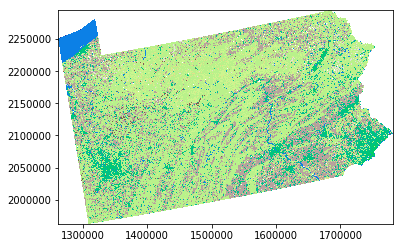

In [75]:
filepath = 'C:/Users/renan/Desktop/harmonization_osnap/NLCD2011_LC_Pennsylvania/NLCD2011_LC_Pennsylvania.tif'
dem = rasterio.open(filepath)
show(dem, cmap='terrain')

# Importing some actual population data

In [76]:
import os
os.chdir('C:\\Users\\renan\\Desktop\\osnap_data')
from osnap.data import read_ltdb

sample = "LTDB_Std_All_Sample.zip"
full = "LTDB_Std_All_fullcount.zip"

df_pre = read_ltdb(sample = sample, fullcount = full)

df = df_pre[['n_total_pop', 'year']]

df['geoid'] = df.index
df['state'] = df['geoid'].str[0:2]
df.head()

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,n_total_pop,year,geoid,state
geoid,,,,
01001020500,9.0,1970,01001020500,01
01003010100,3470.0,1970,01003010100,01
01003010200,1881.0,1970,01003010200,01
01003010300,3724.0,1970,01003010300,01
01003010400,2600.0,1970,01003010400,01


In [77]:
df_pa_1990 = df[(df['state'] == '42') & (df['year'] == 1990)][['geoid', 'n_total_pop']]
df_pa_2000 = df[(df['state'] == '42') & (df['year'] == 2000)][['geoid', 'n_total_pop']]

In [78]:
profiled_pa_2000 = append_profile_in_gdf(pa_2000, raster = dem)
profiled_pa_2000['Total_Pixels'] = profiled_pa_2000.loc[:, profiled_pa_2000.columns.str.startswith('Type_')].sum(axis = 1)
profiled_pa_2000.head()

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Type_0,Type_11,Type_21,Type_22,Type_23,Type_24,Type_255,Type_31,Type_41,Type_42,...,Type_52,Type_71,Type_81,Type_82,Type_90,Type_95,geoid,geometry,wkb,Total_Pixels
0,NaN,504.0,5900.0,1456.0,369.0,74.0,78118,13.0,11548.0,432.0,...,4587.0,317.0,14303.0,19041.0,2696.0,137.0,42001030101,"POLYGON ((-77.094376 39.994956, -77.094802 39....",0103000000010000003A010000BF61A2410A4653C0C07A...,139860.0
1,NaN,870.0,6655.0,2422.0,429.0,70.0,87720,74.0,11223.0,556.0,...,4752.0,397.0,19667.0,27071.0,2249.0,226.0,42001030102,"POLYGON ((-77.097065 39.947374, -77.099249 39....",010300000001000000E701000085251E50364653C0558A...,164808.0
2,NaN,180.0,9717.0,3195.0,929.0,147.0,157421,34.0,24404.0,680.0,...,9408.0,568.0,35855.0,42651.0,5555.0,423.0,42001030200,"POLYGON ((-77.126577 39.908316, -77.127557 39....",0103000000010000005701000040DB6AD6194853C07E37...,292110.0
3,NaN,452.0,10015.0,1593.0,477.0,191.0,98528,NaN,56542.0,6413.0,...,2036.0,252.0,29966.0,9006.0,1344.0,104.0,42001030300,"POLYGON ((-77.351641 39.944281, -77.35173 39.9...",010300000001000000BA000000B2BB4049815653C0F99D...,222939.0
4,NaN,999.0,11942.0,3244.0,387.0,38.0,125888,183.0,97451.0,13469.0,...,1016.0,676.0,20985.0,33727.0,3917.0,722.0,42001030400,"POLYGON ((-77.463875 39.860685, -77.464944 39....",01030000000100000061010000A69BC420B05D53C03194...,325822.0


In [79]:
full_pa_2000 = profiled_pa_2000.merge(df_pa_2000, on = 'geoid')

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\geodataframe.py:475: FutureWarning: 'geoid' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)


In [123]:
t0 = time.time()
correspondence_table = create_non_zero_population_by_pixels_locations(full_pa_2000, dem, 'n_total_pop')
t1 = time.time()
print('Total time taken: {}'.format(t1-t0))

Total time taken: 575.9370069503784


When you clip a specific polygon, there a pixel that lies beyond the polygon extent. Therefore, the population could be wrongly summed from another tract! A possible solution is to build a pandas and filter the pixels different than 255. This will be done later.

Doing this through **pandas**.

In [128]:
corresp.head()

,pop_value,lons,lats,polygon
0,0.135041,1584675,2052555,0.0
1,0.135041,1584705,2052555,0.0
2,0.135041,1584735,2052555,0.0
3,0.135041,1584765,2052555,0.0
4,0.135041,1584795,2052555,0.0


In [118]:
data = {'pop_value': np.ndarray.flatten(correspondence_table[0]),
        'lons': np.ndarray.flatten(correspondence_table[1]).round().astype(int).tolist(), 
        'lats': np.ndarray.flatten(correspondence_table[2]).round().astype(int).tolist(),
        'polygon': np.ndarray.flatten(correspondence_table[3])}
corresp = pd.DataFrame.from_dict(data)
corresp.head()

,pop_value,lons,lats,polygon
0,0.135041,1584675,2052555,0.0
1,0.135041,1584705,2052555,0.0
2,0.135041,1584735,2052555,0.0
3,0.135041,1584765,2052555,0.0
4,0.135041,1584795,2052555,0.0


# Extracting a specific polygon from the original geopandas

In [129]:
geo = full_pa_2000[full_pa_2000.geoid == '42133010120']

geo.crs = {'init': 'epsg:4326'}
geo_projected = geo.to_crs(crs = dem.crs.data)

coords = getFeatures(geo_projected)
out_img, out_transform = mask(dataset = dem, shapes = coords, crop = True)
lons, lats = create_lon_lat(out_img, out_transform)

geo_projected

,Type_0,Type_11,Type_21,Type_22,Type_23,Type_24,Type_255,Type_31,Type_41,Type_42,...,Type_71,Type_81,Type_82,Type_90,Type_95,geoid,geometry,wkb,Total_Pixels,n_total_pop
2421,NaN,10.0,4101.0,1902.0,930.0,753.0,10007,25.0,2504.0,143.0,...,NaN,866.0,1021.0,89.0,NaN,42133010120,"POLYGON ((1621954.396248104 2050190.798474984,...",0103000000010000005C000000CE1C925A282D53C0C7BB...,23055.0,4223.0


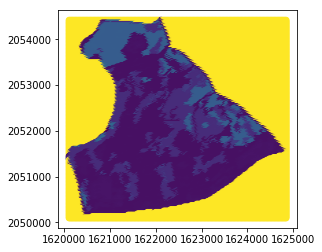

In [134]:
data = {'lons': np.ndarray.flatten(lons).round().astype(int).tolist(), 
        'lats': np.ndarray.flatten(lats).round().astype(int).tolist(),
        'pixel_value': np.ndarray.flatten(out_img)}
polygon_summary = pd.DataFrame.from_dict(data)


polygon_summary['geometry'] = list(zip(polygon_summary.lons, polygon_summary.lats))
polygon_summary['geometry'] = polygon_summary.geometry.apply(Point)
polygon_summary = gpd.GeoDataFrame(polygon_summary)

polygon_summary.plot(column = 'pixel_value')

In [154]:
polygon_summary['pixel_value'].head()

0    255
1    255
2    255
3    255
4    255
Name: pixel_value, dtype: uint8

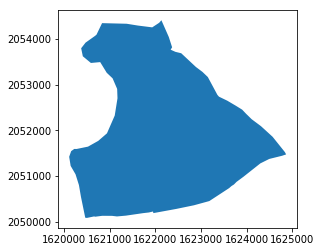

In [131]:
geo_projected.plot()

You have population in pixels that is 255. This is makes sense, but this is population from **ANOTHER TRACT** and, therefore, must be removed.

In [132]:
merged_polygon = correspondence_table.merge(polygon_summary, on=['lons', 'lats'])
merged_polygon.head()

,pop_value,lons,lats,pixel_value,geometry
0,0.668690,1622145,2054415,255,POINT (1622145 2054415)
1,0.201375,1622175,2054415,255,POINT (1622175 2054415)
2,0.201375,1622205,2054415,255,POINT (1622205 2054415)
3,0.201375,1622235,2054415,255,POINT (1622235 2054415)
4,0.201375,1622265,2054415,255,POINT (1622265 2054415)


In [138]:
type(merged_polygon)

pandas.core.frame.DataFrame

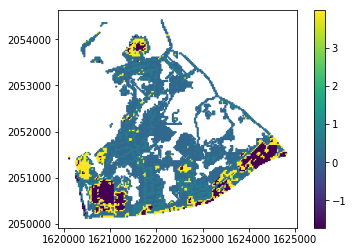

In [152]:
gpd.GeoDataFrame(merged_polygon[merged_polygon.pixel_value != 255]).plot(column = 'pop_value', 
                                                                         legend = True,
                                                                         markersize = 1.5)

In [133]:
merged_polygon[merged_polygon.pixel_value != 255]['pop_value'].sum()

4223.0

And this matches with the original population!

In [127]:
full_pa_2000[full_pa_2000.geoid == '42133010120']['n_total_pop']

2421    4223.0
Name: n_total_pop, dtype: float64

**Therefore, we can estimate any amount of population with any kind of different clipping by only using this correspondence_table of pixels and population from Pennsylvania!!!**

One important thing to notice is that the same tract id from a different year (1990) produced a slightly different population number (4188 in face of the previous 4223). However, this is due to the fact that actually **the polygon that was read (it could be from a shapefile, for example) is different from the one ofe 2000.** This change can be seen when you overlap both polyon and see the difference.

In [119]:
geo_1990 = df_1990[df_1990.geoid == '42133010120']

geo_1990.crs = {'init': 'epsg:4326'}
geo_1990_projected = geo_1990.to_crs(crs = dem.crs.data)

coords = getFeatures(geo_1990_projected)
out_img, out_transform = mask(dataset = dem, shapes = coords, crop = True)
lons, lats = create_lon_lat(out_img, out_transform)
data = {'lons': np.ndarray.flatten(lons).round().astype(int).tolist(), 
        'lats': np.ndarray.flatten(lats).round().astype(int).tolist(),
        'pixel_value': np.ndarray.flatten(out_img)}
polygon_summary = pd.DataFrame.from_dict(data)


polygon_summary['geometry'] = list(zip(polygon_summary.lons, polygon_summary.lats))
polygon_summary['geometry'] = polygon_summary.geometry.apply(Point)
polygon_summary = gpd.GeoDataFrame(polygon_summary)

merged_polygon = corresp.merge(polygon_summary, on=['lons', 'lats'])
merged_polygon[merged_polygon.pixel_value != 255]['pop_value'].sum()

4188.3204893828215

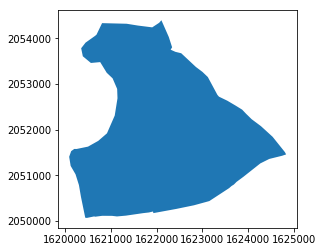

In [89]:
geo_1990_projected.plot()

In [90]:
geo_union = gpd.overlay(geo_1990_projected, geo_projected, how='union')

It has 3 polygons in the overlay!

In [92]:
len(geo_union)

3

In [93]:
geo_union 

,geoid_1,index,wkb_1,Type_0,Type_11,Type_21,Type_22,Type_23,Type_24,Type_255,...,Type_71,Type_81,Type_82,Type_90,Type_95,geoid_2,wkb_2,Total_Pixels,n_total_pop,geometry
0,42133010120,None,010300000001000000580000008FE4F21FD22B53C02EFF...,NaN,10.0,4101.0,1902.0,930.0,753.0,10007.0,...,NaN,866.0,1021.0,89.0,NaN,42133010120,0103000000010000005C000000CE1C925A282D53C0C7BB...,23055.0,4223.0,"POLYGON ((1623640.801690686 2050767.190983921,..."
1,42133010120,None,010300000001000000580000008FE4F21FD22B53C02EFF...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(POLYGON ((1624833.745860677 2051466.903217599...
2,NaN,NaN,NaN,NaN,10.0,4101.0,1902.0,930.0,753.0,10007.0,...,NaN,866.0,1021.0,89.0,NaN,42133010120,0103000000010000005C000000CE1C925A282D53C0C7BB...,23055.0,4223.0,(POLYGON ((1622109.730865425 2054390.536005182...


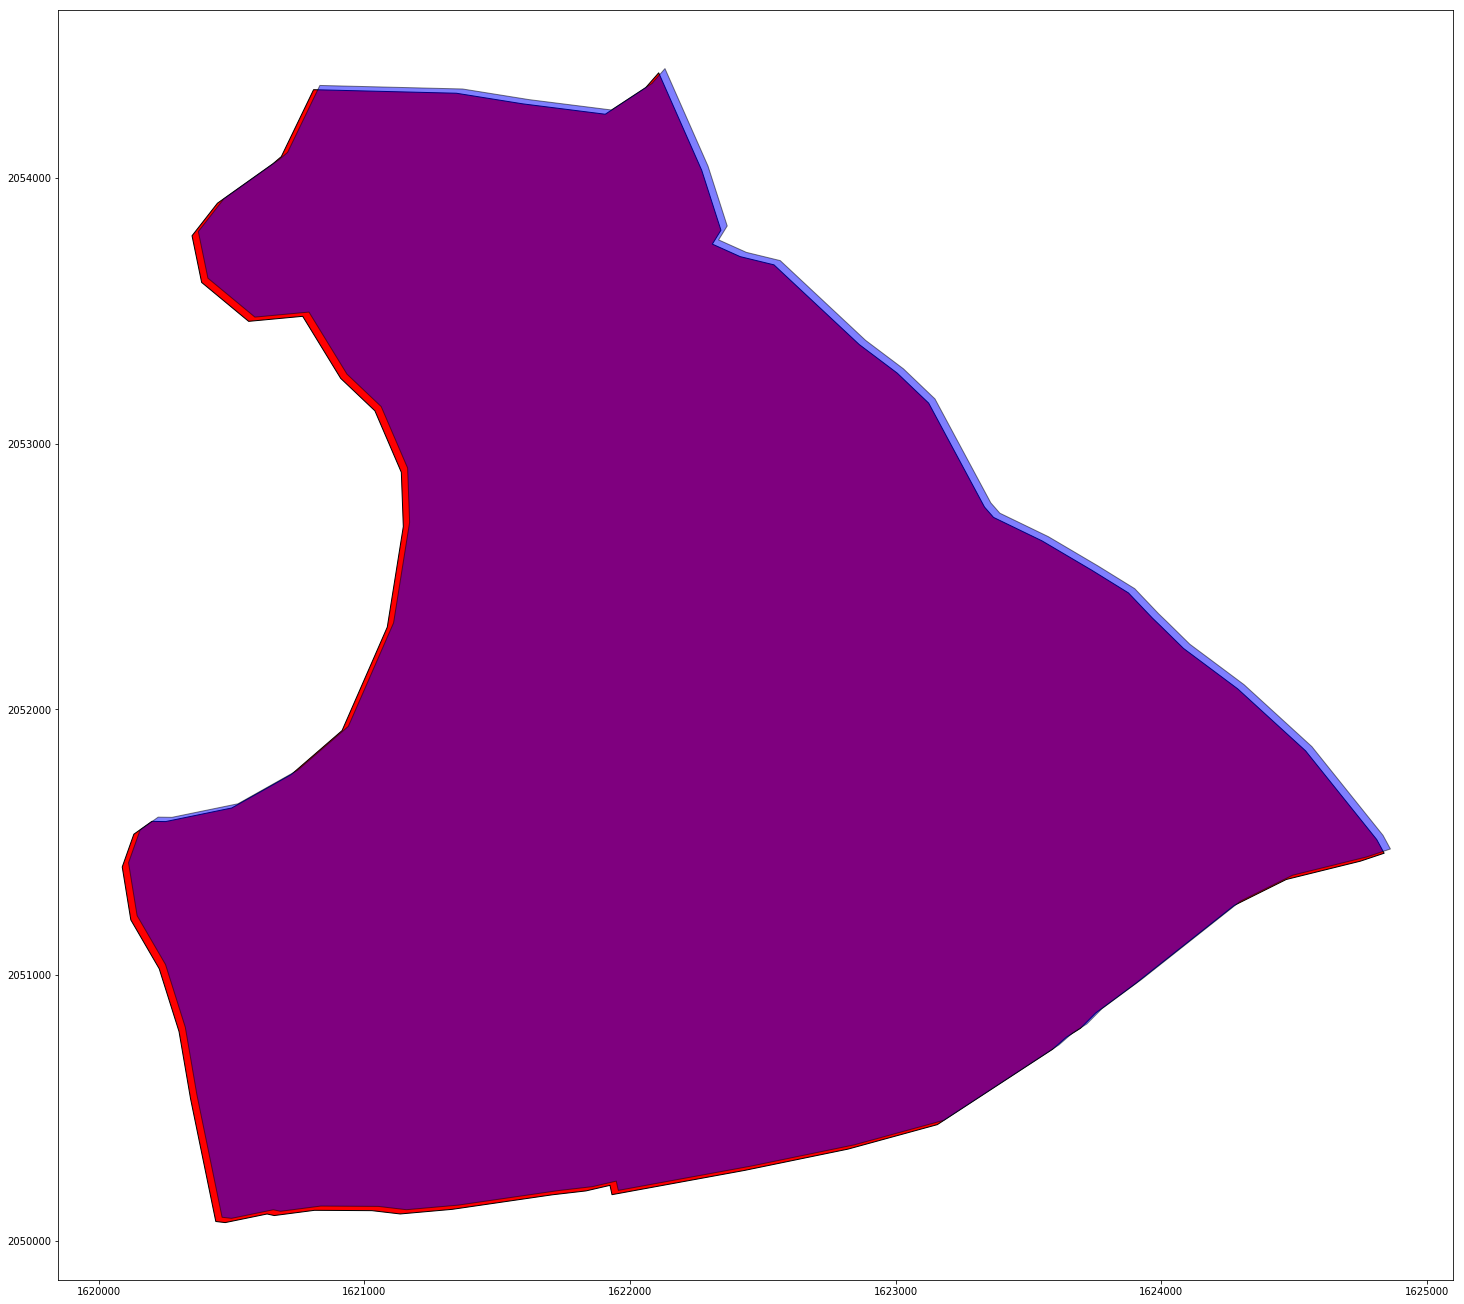

In [94]:
ax = geo_1990_projected.plot(color='red', edgecolor='k', figsize = (25, 25))
geo_projected.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', figsize = (20, 20))

# Comparing a polygon that changed a lot the area

In [158]:
df_1990['area'] = df_1990.area
df_1990.head()

,geoid,index,wkb,geometry,area
0,01023009567,None,0103000000010000007B070000DC9C4A06801A56C08C85...,"POLYGON ((-88.414064 32.179518, -88.414226 32....",0.055654
1,01023009568,None,010300000001000000F6090000A3E5400FB51456C02462...,"POLYGON ((-88.32355099999999 32.02982, -88.324...",0.072559
2,01023009569,None,0103000000010000008B040000840EBA84431D56C001C1...,"POLYGON ((-88.457246 31.81052, -88.458158 31.8...",0.055296
3,01023009570,None,01030000000100000082020000FA7C9411170C56C00E88...,"POLYGON ((-88.188908 31.698461, -88.194 31.698...",0.044157
0,01037009610,None,01030000000100000032030000A62BD8463C8655C0950C...,"POLYGON ((-86.09742900000001 32.912974, -86.09...",0.024391


In [159]:
full_pa_2000['area'] = full_pa_2000.area
full_pa_2000.head()

,Type_0,Type_11,Type_21,Type_22,Type_23,Type_24,Type_255,Type_31,Type_41,Type_42,...,Type_81,Type_82,Type_90,Type_95,geoid,geometry,wkb,Total_Pixels,n_total_pop,area
0,NaN,504.0,5900.0,1456.0,369.0,74.0,78118,13.0,11548.0,432.0,...,14303.0,19041.0,2696.0,137.0,42001030101,"POLYGON ((-77.094376 39.994956, -77.094802 39....",0103000000010000003A010000BF61A2410A4653C0C07A...,139860.0,2489.0,0.005861
1,NaN,870.0,6655.0,2422.0,429.0,70.0,87720,74.0,11223.0,556.0,...,19667.0,27071.0,2249.0,226.0,42001030102,"POLYGON ((-77.097065 39.947374, -77.099249 39....",010300000001000000E701000085251E50364653C0558A...,164808.0,5106.0,0.007313
2,NaN,180.0,9717.0,3195.0,929.0,147.0,157421,34.0,24404.0,680.0,...,35855.0,42651.0,5555.0,423.0,42001030200,"POLYGON ((-77.126577 39.908316, -77.127557 39....",0103000000010000005701000040DB6AD6194853C07E37...,292110.0,5122.0,0.012782
3,NaN,452.0,10015.0,1593.0,477.0,191.0,98528,NaN,56542.0,6413.0,...,29966.0,9006.0,1344.0,104.0,42001030300,"POLYGON ((-77.351641 39.944281, -77.35173 39.9...",010300000001000000BA000000B2BB4049815653C0F99D...,222939.0,3547.0,0.011805
4,NaN,999.0,11942.0,3244.0,387.0,38.0,125888,183.0,97451.0,13469.0,...,20985.0,33727.0,3917.0,722.0,42001030400,"POLYGON ((-77.463875 39.860685, -77.464944 39....",01030000000100000061010000A69BC420B05D53C03194...,325822.0,5433.0,0.018950


In [164]:
both_df = df_1990[['geoid', 'geometry', 'area']].merge(full_pa_2000[['geoid', 'geometry', 'area']], on = 'geoid')
both_df['diff_area'] = both_df['area_x'] - both_df['area_y']
both_df.sort_values('diff_area').head()

,geoid,geometry_x,area_x,geometry_y,area_y,diff_area
544,42077006302,"POLYGON ((-75.592528 40.512304, -75.5889119999...",0.000195,"POLYGON ((-75.628224 40.509071, -75.6303220000...",0.002726,-0.002532
275,42011011703,"POLYGON ((-75.902236 40.155441, -75.903594 40....",0.003465,"POLYGON ((-75.901894 40.155537, -75.9032519999...",0.004017,-0.000552
38,42091200501,"POLYGON ((-75.13720000000001 40.192, -75.1384 ...",0.000407,"POLYGON ((-75.13291700000001 40.194108, -75.13...",0.000837,-0.000431
0,42133010110,"POLYGON ((-76.67165799999999 39.991837, -76.67...",0.001586,"POLYGON ((-76.632288 39.982498, -76.631928 39....",0.001784,-0.000198
436,42029303801,"POLYGON ((-75.732849 39.948707, -75.73442 39.9...",0.002404,"POLYGON ((-75.687845 39.923165, -75.688044 39....",0.002591,-0.000186


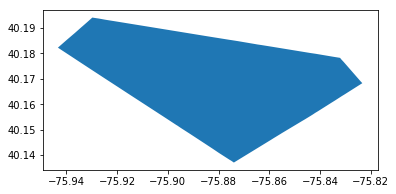

In [168]:
df_1990[df_1990.geoid == '42011011703'].plot()

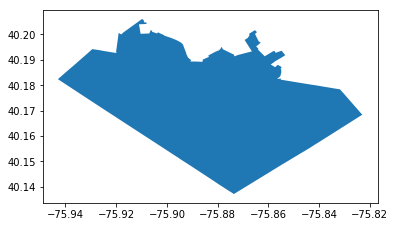

In [169]:
full_pa_2000[full_pa_2000.geoid == '42011011703'].plot()

In [170]:
def calculate_polygon_population_from_correspondence_NLCD_table(polygon, raster, corresp_table):

    polygon.crs = {'init': 'epsg:4326'}
    polygon_projected = polygon.to_crs(crs = raster.crs.data)

    coords = getFeatures(polygon_projected)
    out_img, out_transform = mask(dataset = raster, shapes = coords, crop = True)
    lons, lats = create_lon_lat(out_img, out_transform)
    data = {'lons': np.ndarray.flatten(lons).round().astype(int).tolist(), 
            'lats': np.ndarray.flatten(lats).round().astype(int).tolist(),
            'pixel_value': np.ndarray.flatten(out_img)}
    polygon_summary = pd.DataFrame.from_dict(data)
    
    merged_polygon = corresp_table.merge(polygon_summary, on = ['lons', 'lats'])
    
    pop = merged_polygon[merged_polygon.pixel_value != 255]['pop_value'].sum()
    
    return pop

In [192]:
calculate_polygon_population_from_correspondence_NLCD_table(df_1990[df_1990.geoid == '42011011703'], 
                                                            dem, 
                                                            correspondence_table)

2363.116630405465

In [224]:
polygon = df_1990[df_1990.geoid == '42011011703']

polygon.crs = {'init': 'epsg:4326'}
polygon_projected = polygon.to_crs(crs = dem.crs.data)

coords = getFeatures(polygon_projected)
out_img, out_transform = mask(dataset = dem, shapes = coords, crop = True)
lons, lats = create_lon_lat(out_img, out_transform)
data = {'lons': np.ndarray.flatten(lons).round().astype(int).tolist(), 
        'lats': np.ndarray.flatten(lats).round().astype(int).tolist(),
        'pixel_value': np.ndarray.flatten(out_img)}
polygon_summary = pd.DataFrame.from_dict(data)

merged_polygon = correspondence_table.merge(polygon_summary, on = ['lons', 'lats'])

merged_polygon['geometry'] = list(zip(merged_polygon.lons, merged_polygon.lats))
merged_polygon['geometry'] = merged_polygon.geometry.apply(Point)
merged_polygon = gpd.GeoDataFrame(merged_polygon)

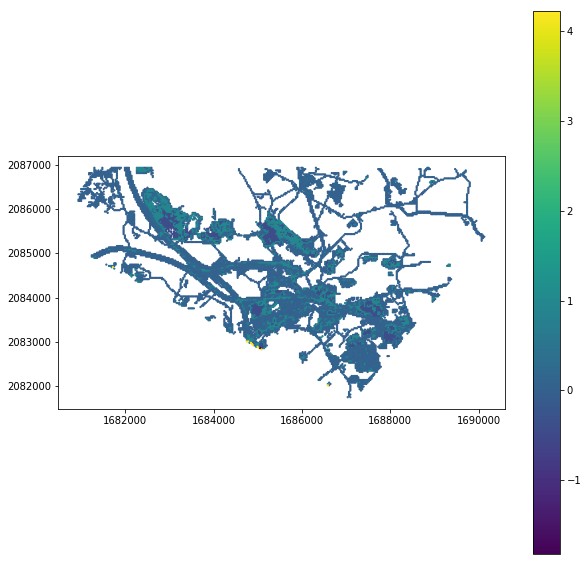

In [205]:
gpd.GeoDataFrame(merged_polygon[merged_polygon.pixel_value != 255]).plot(column = 'pop_value', 
                                                                         legend = True,
                                                                         markersize = 1.5,
                                                                         figsize = (10,10))

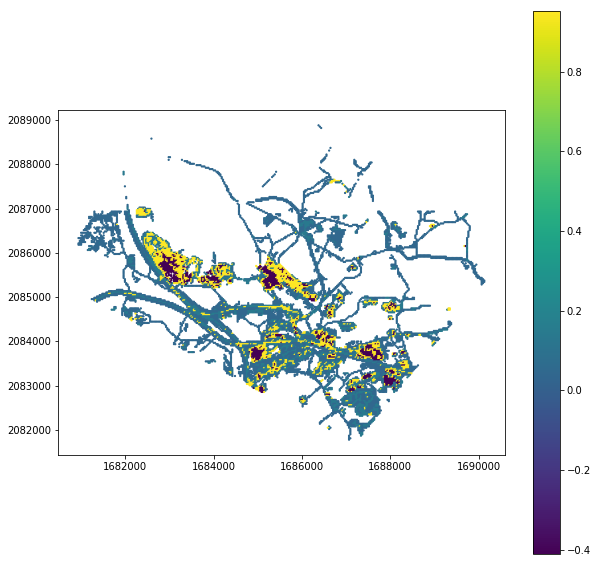

In [201]:
gpd.GeoDataFrame(merged_polygon[merged_polygon.pixel_value != 255]).plot(column = 'pop_value', 
                                                                         legend = True,
                                                                         markersize = 1.5,
                                                                         figsize = (10,10))

In [222]:
correspondence_table.pop_value.min()

-3950.0363472853032

In [227]:
polygon = df_1990[df_1990.geoid == '42011011703']

polygon.crs = {'init': 'epsg:4326'}
polygon_projected1 = polygon.to_crs(crs = dem.crs.data)


polygon = full_pa_2000[full_pa_2000.geoid == '42011011703']

polygon.crs = {'init': 'epsg:4326'}
polygon_projected2 = polygon.to_crs(crs = dem.crs.data)

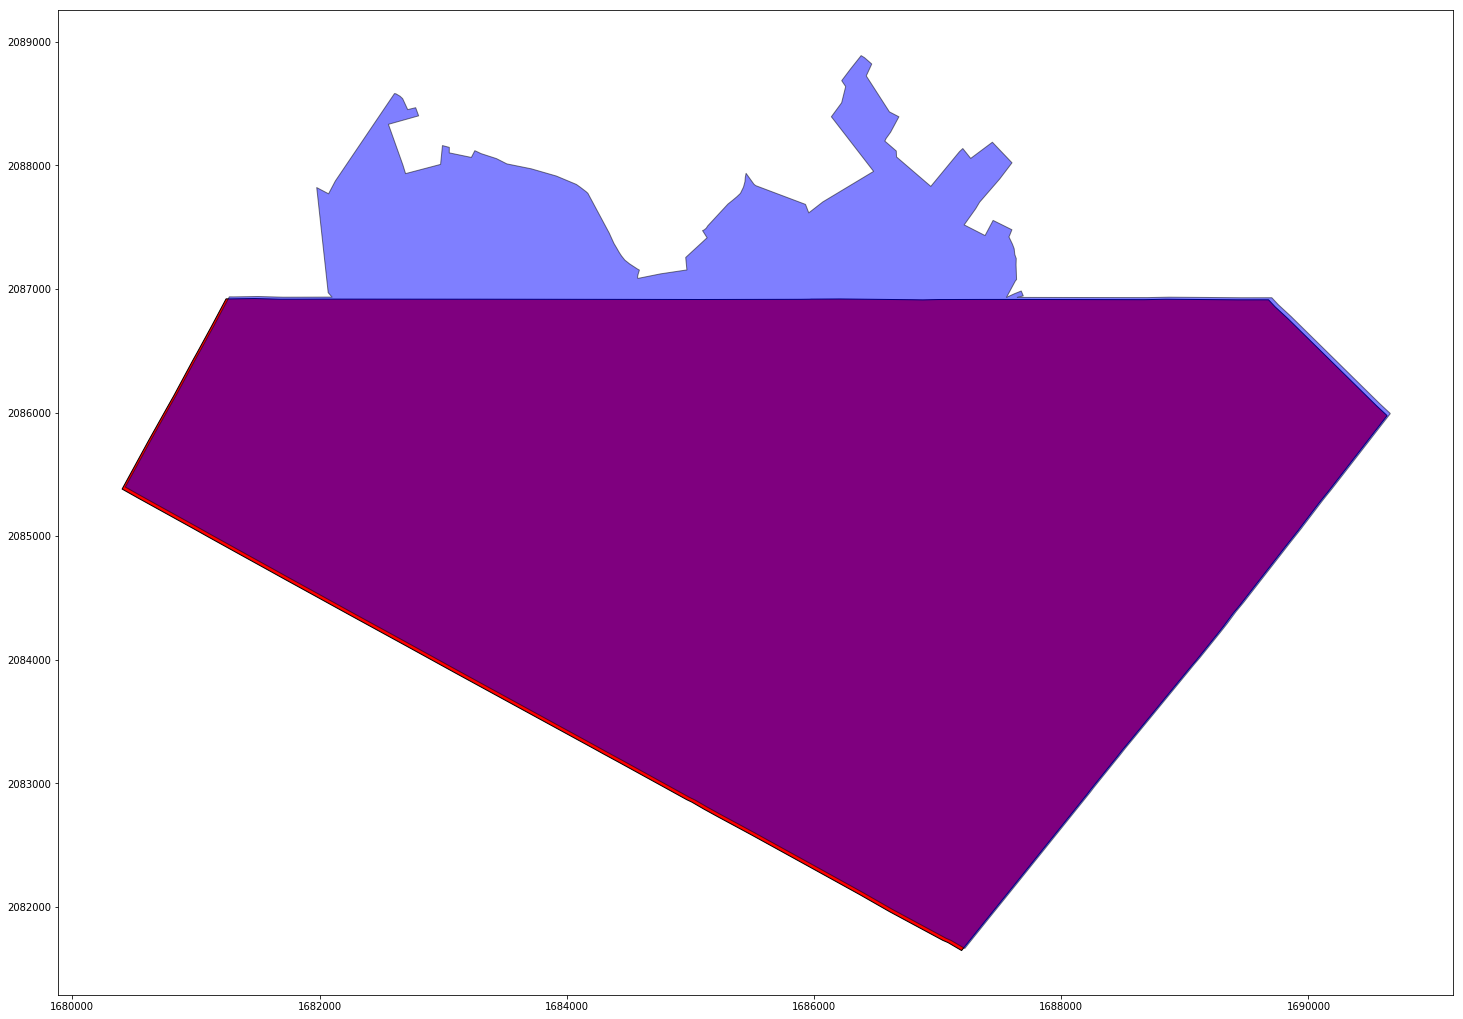

In [228]:
ax = polygon_projected1.plot(color='red', edgecolor='k', figsize = (25, 25))
polygon_projected2.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', figsize = (20, 20))

It is not the same pixels, not event in the borders.